In [1]:
# Basic utilities
import re
import sys
from datetime import date
from copy import deepcopy
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

# Data wrangling packages
import numpy as np
from scipy import stats
from skimage.filters import threshold_yen

# Cellpose - the current belle of the ball
from cellpose import models, io

# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Cell Segmentation', 'Imaging Utilities', str(sys.path[0]))

# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
from skimage.segmentation import find_boundaries

from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import io
import glob
from skimage.filters import threshold_local
from skimage.filters import threshold_li
from skimage.color import rgb2gray
from math import sqrt
from skimage.morphology import disk, ball
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.filters.rank import enhance_contrast
from skimage.exposure import adjust_gamma
import pickle as pkl
import sys
from datetime import date
import os, psutil
import re
process = psutil.Process(os.getpid())
# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))
# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
#import ims_file_utils as ims
#import image_processing_utils as impro
#import plotting_funcs as plot
from functools import reduce
from scipy.spatial.distance import cdist, pdist
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries

# Use this function for local thresholding of images
def lthresh(imgstk):
    th = threshold_local(imgstk, 65, offset=0)
    imgstk = imgstk>= th
    return imgstk
# Use this function to threshold images
def thresh(imgstk):
    th = threshold_li(imgstk)
    imgstk = imgstk>= th
    return imgstk
def spotcall(img, min_sig, max_sig, nsig, th):
    blobs_log = blob_log(img, min_sigma=min_sig, max_sigma=max_sig, num_sigma=nsig, threshold=th)
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    color = 'lime'
    title = 'Laplacian of Gaussian'
    #plt.rcParams['figure.figsize'] = [20, 15]
    #fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    #ax.set_title(title)
    #ax.imshow(img)
    #for blob in blobs_log:
    #    y, x, r = blob
    #    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    #    ax.add_patch(c)
    #ax.set_axis_off()
    #plt.tight_layout()
    #plt.show()
    return blobs_log


# Basic utilities
from datetime import date
from copy import deepcopy
# Data wrangling packages
from scipy import stats
from skimage.filters import threshold_yen
# Cellpose - the current belle of the ball
from cellpose import models, io
import pandas as pd
from math import sqrt

In [2]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True
# make config if it does not exist already (e.g. passed in by papermill) for manual running
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_url" : "/mnt/disks/external/jg4159/20220914_irradiation_DDR364/RegisteredImages_20220914_irradiation_DDR364-B1-1.pkl",
    }
print(config)

{'data_url': '/mnt/disks/external/jg4159/20220914_irradiation_DDR364/RegisteredImages_20220914_irradiation_DDR364-B1-1.pkl'}


In [3]:
config = {
        "data_url" : "P1_1",
    }
print(config)

{'data_url': 'P1_1'}


In [4]:
runName = config['data_url']
opdir = '/mnt/disks/external/jg4159/20231006_DDR364/' # Path to output
ip = opdir + "RegisteredImages_Ab_" + runName + ".pkl"
print(ip)
filehandler = open(ip, 'rb')
img_stack = pkl.load(filehandler)
filehandler.close()

/mnt/disks/external/jg4159/20231006_DDR364/RegisteredImages_Ab_P1_1.pkl


In [5]:
### VARIABLE DEFINITION ###
maxpro = True # Set false if 3D registration required
interactive = False #If true will show napari visualizations
# filehandler = open(ip, 'rb')
# img_stack = pkl.load(filehandler)
# filehandler.close()

## Rescale image and set manual threshold 

In [6]:
cell_diam = 50
# nuc and mem image thresholding
nuc_p2 = 101
nuc_p98 = 180
#file2.write(f"nuc_p2 = {nuc_p2}, nuc_p98 = {nuc_p98} \n")
mem_p2 = 101
mem_p98 = 115
#file2.write(f"mem_p2 = {mem_p2}, mem_p98 = {mem_p98} \n")
nuc = rescale_intensity(img_stack[0][4], (nuc_p2,nuc_p98), (0, 255))
mem = rescale_intensity(img_stack[0][0], (mem_p2,mem_p98), (0, 255))

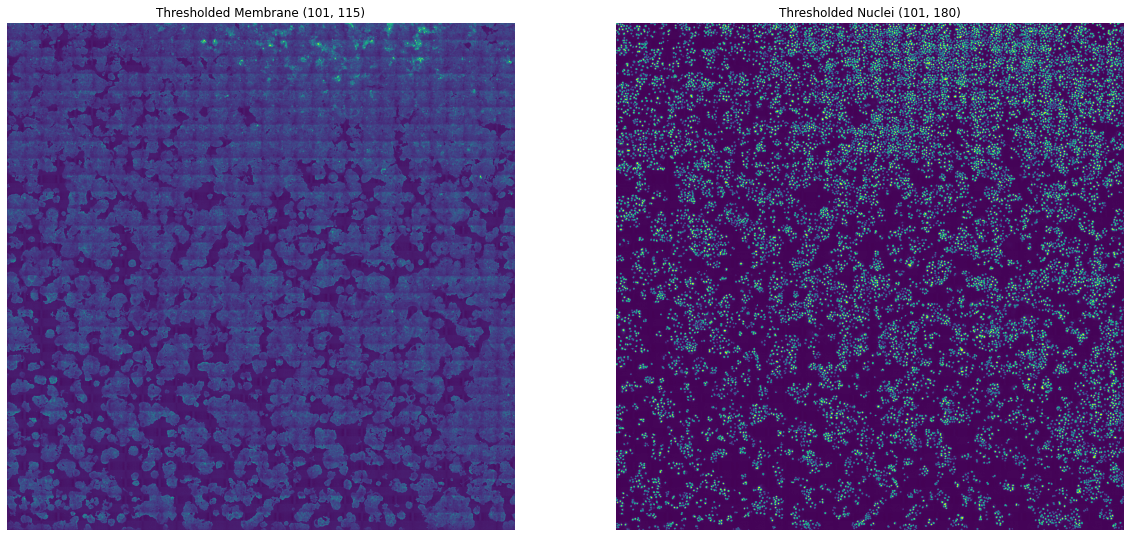

In [7]:
# save plots to a PDF
#pp = PdfPages(opdir+"Segmentation-"+runName+"_"+str(mem_p2)+ "_" +str(mem_p98)+ "_" +str(nuc_p2)+ "_" +str(nuc_p98)+ "_" +str(cell_diam)+'-output-images.pdf')
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1, 2)  
axarr[0].imshow(mem)
axarr[0].set_title(f"Thresholded Membrane ({mem_p2}, {mem_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(nuc)
axarr[1].set_title(f"Thresholded Nuclei ({nuc_p2}, {nuc_p98})")
axarr[1].set_axis_off()
        
#f.tight_layout()
#f.savefig(pp, format='pdf')

In [8]:
# nuclei segmentation


stack_nuclei = np.stack((nuc, np.zeros(nuc.shape)), axis = 2) #nuc_idx
model = models.Cellpose(gpu=False, model_type='nuclei')
masks_nuc, flows, styles, diams = model.eval(stack_nuclei,
                                             channels=[0,0],
                                             do_3D = False,
                                             diameter = int(cell_diam/2))
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# ax[0].imshow(nuc)
# ax[1].imshow(find_boundaries(masks_nuc))

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 2705.24s; flow+mask computation 801.79
estimated masks for 1 image(s) in 3511.07 sec
>>>> TOTAL TIME 3511.07 sec


In [9]:
cell_prob_thresh = 0.0
stack_membrane = np.stack((mem, nuc), axis = 2) # mem_idx, nuc_idx
# run Cellpose on both membranes and nuclei separately
model = models.Cellpose(gpu=False, model_type='cyto')
masks_mem, flows, styles, diams = model.eval(stack_membrane, 
                                             channels=[1,2], 
                                             do_3D = False,
                                             diameter = cell_diam, 
                                             cellprob_threshold = cell_prob_thresh, 
                                             min_size = 5)
# fig, ax = plt.subplots(1, 2, figsize=(45, 45))
# ax[0].imshow(mem)
# ax[1].imshow(find_boundaries(masks_mem))

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 176.70s; flow+mask computation 826.59
estimated masks for 1 image(s) in 1007.01 sec
>>>> TOTAL TIME 1007.01 sec


In [10]:
# Flatten image
flat_nuc = masks_nuc.ravel()
flat_mem = masks_mem.ravel()
# Remove the 0 (null) id since it is not a cell
nuc_ids = np.unique(flat_nuc)
nuc_ids = nuc_ids[nuc_ids!=0]
mem_ids = np.unique(flat_mem)
mem_ids = mem_ids[mem_ids!=0]
#file2.write(f"Nuclei identified: {len(nuc_ids)} \n")
#file2.write(f"Membrane identified: {len(mem_ids)} \n")
#Remove nuc below thres
# nuc_size_thresh = 50
# file2.write(f"nuc_size_thresh = {nuc_size_thresh} \n")
# for i in range(len(nuc_ids)): 
#     nuc_pxls = np.where(flat_nuc==nuc_ids[i])[0]
#     if len(nuc_pxls) < nuc_size_thresh:
#         flat_nuc[nuc_pxls]=0
# print(len(np.unique(flat_nuc)))
# file2.write(f"Nuclei above nuc_size_thresh: {len(np.unique(flat_nuc))} \n")
# Create the dictionary
ref_mem = dict()
for i in range(len(mem_ids)):    
    # Get Indices of Nuclei volume & append to dictionary
    mem_pxls = np.where(flat_mem==mem_ids[i])[0]
    # Get the most common membrane mask value for that location
    nucs = flat_nuc[mem_pxls]
    if sum(nucs)>0: #nuc present
        nucs = nucs[nucs!=0] #non-zero nuc_ids
        nuc_id = stats.mode(nucs)[0][0] # pick the mode as the nuc_id
        nuc_pxls = np.where(flat_nuc==nuc_id)[0]
        if len(np.unique(nucs)) > 1: #multiple nuc_id present
            second_nucs = nucs[nucs!=nuc_id] #non-zero nuc_ids
            second_nuc_id = stats.mode(second_nucs)[0][0] # pick the mode as the nuc_id
            second_nuc_pxls = np.where(flat_nuc==second_nuc_id)[0]
        else: # no other nuc_ids
            second_nuc_id = 0
            second_nuc_pxls = [0]
       # Save within a sub dictionary
        sub_dict = dict()
        sub_dict["nuc_id"] = nuc_id
        sub_dict["nuc_present"] = len(np.unique(nucs))
        sub_dict["second_nuc_id"] = second_nuc_id
        sub_dict["second_nuc_pxls"] = second_nuc_pxls
        sub_dict['Nuclei Pixels'] = nuc_pxls
        sub_dict['Membrane Pixels'] = mem_pxls
        # save the sub dictionary
        ref_mem[mem_ids[i]] = sub_dict
print(len(ref_mem))
#file2.write(f"Membrane-nuclei pairs: {len(ref_mem)} \n")

14793


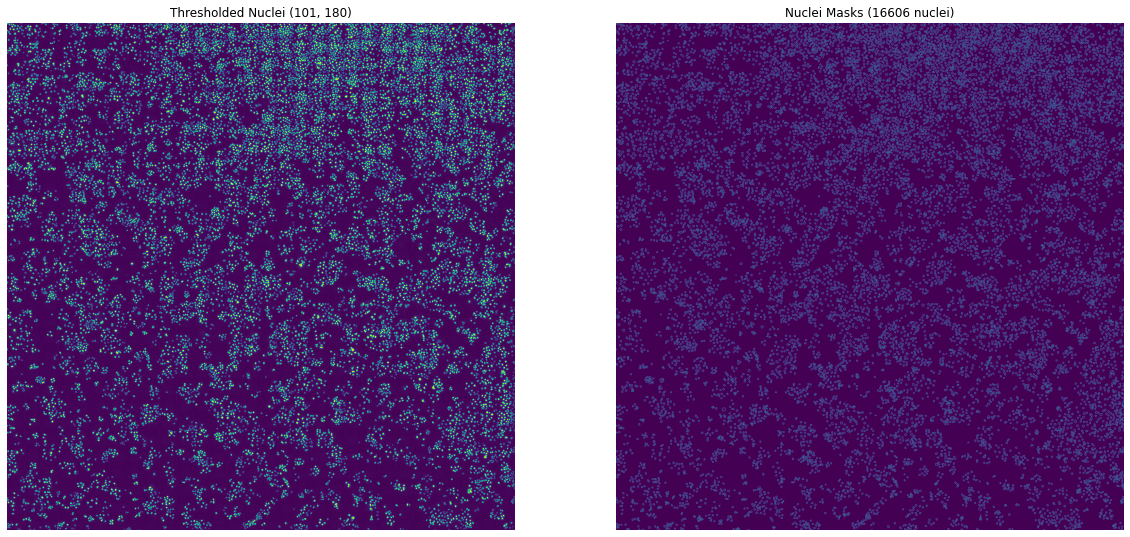

In [11]:
f, axarr = plt.subplots(1, 2) 
axarr[0].imshow(nuc)
axarr[0].set_title(f"Thresholded Nuclei ({nuc_p2}, {nuc_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(find_boundaries(masks_nuc))
axarr[1].set_title(f"Nuclei Masks ({len(np.unique(flat_nuc))} nuclei)")
axarr[1].set_axis_off()
        
#f.tight_layout()
#f.savefig(pp, format='pdf')

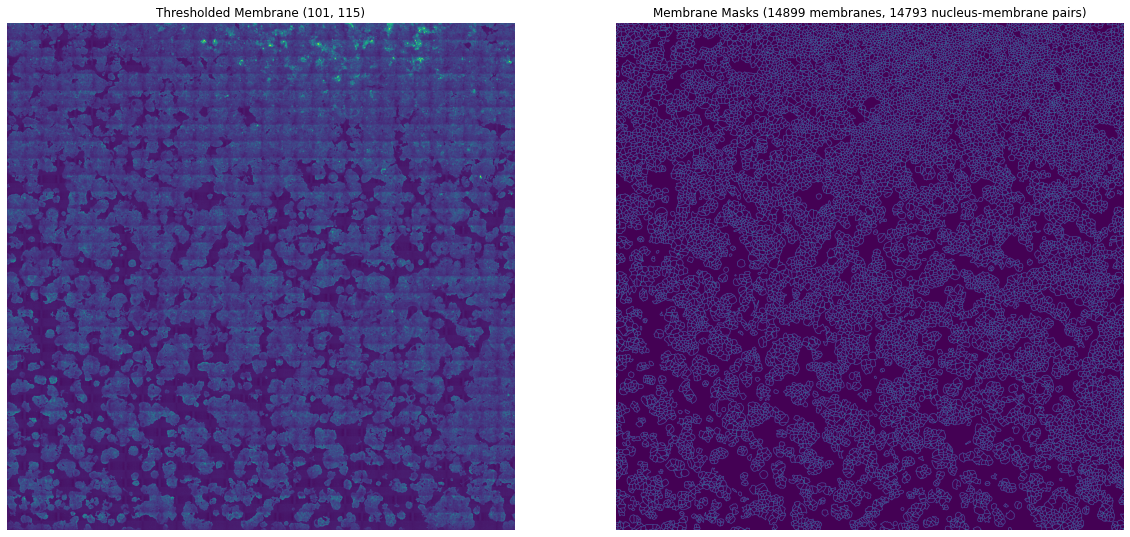

In [12]:
f, axarr = plt.subplots(1, 2) 
axarr[0].imshow(mem)
axarr[0].set_title(f"Thresholded Membrane ({mem_p2}, {mem_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(find_boundaries(masks_mem))
axarr[1].set_title(f"Membrane Masks ({len(np.unique(flat_mem))} membranes, {len(ref_mem)} nucleus-membrane pairs)")
axarr[1].set_axis_off()
        
#f.tight_layout()
#f.savefig(pp, format='pdf')

In [13]:
# Generate 2D masks
import time
start_time = time.time()

# Convert ref_mem to 2Dimensional coordinates
nuclei_mask = np.zeros(masks_nuc.shape)
membrane_mask = np.zeros(masks_mem.shape)
nucMask_flat = nuclei_mask.ravel()
memMask_flat = membrane_mask.ravel()

for i, cellID in enumerate(ref_mem):
    nuc_id = ref_mem[cellID]["nuc_id"]
    nucMask_flat[ref_mem[cellID]["Nuclei Pixels"]] = nuc_id
    ref_mem[cellID]['Nuclei Pixels 2D'] = np.where(nuclei_mask==nuc_id)
    memMask_flat[ref_mem[cellID]['Membrane Pixels']] = cellID
    ref_mem[cellID]['Membrane Pixels 2D'] = np.where(membrane_mask==cellID)
    if i%1000==0:
        print(f"Finished Membrane {i}")
print(f'--- ref_mem conversion to 2D: {(time.time()-start_time)} seconds')

Finished Membrane 0
Finished Membrane 1000
Finished Membrane 2000
Finished Membrane 3000
Finished Membrane 4000
Finished Membrane 5000
Finished Membrane 6000
Finished Membrane 7000
Finished Membrane 8000
Finished Membrane 9000
Finished Membrane 10000
Finished Membrane 11000
Finished Membrane 12000
Finished Membrane 13000
Finished Membrane 14000
--- ref_mem conversion to 2D: 3559.9203264713287 seconds


In [14]:
filehandler = open(opdir+"Unfiltered_segmentation_DDR364_"+runName + "_"+str(mem_p2)+ "_" +str(mem_p98)+ "_" +str(nuc_p2)+ "_" +str(nuc_p98)+"_"+str(cell_diam)+"_"+str(len(ref_mem)) + '.pickle', 'wb')
pkl.dump((masks_mem, masks_nuc, ref_mem), filehandler)
filehandler.close()

filehandler = open(opdir+"Unfiltered_mask_boundaries_DDR364_"+runName+ "_"+str(mem_p2)+ "_" +str(mem_p98)+ "_" +str(nuc_p2)+ "_" +str(nuc_p98)+"_"+str(cell_diam)+"_"+str(len(ref_mem)) + '.pickle', 'wb')
pkl.dump((find_boundaries(masks_nuc), find_boundaries(masks_mem)), filehandler)
filehandler.close()